In [1]:
# Handling paths for importing code
import sys, os
sys.path.append(os.path.abspath(os.path.join('..')))

from Code.utilities import MSELoss_method, cross_entropy_loss_method, predict, accuracy_func
from Code.descent_methods import SGD_adam, SGD
from Code.data_handling import load_MNIST_8, load_MNIST_28, append_run_to_file, load_run_from_file
from Code.softmax_regression import softmax_beta_init, softmax_model, softmax
from Code.convolutional import _beta_init_conv, convolutional_model_old
from Code.plot import *

from jax import jit, nn, grad
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt

# Set the default font size for text elements (e.g., titles, labels)
import matplotlib as mpl
mpl.rcParams['font.size'] = 16
mpl.rcParams["axes.labelsize"] = 14
mpl.rcParams["axes.titlesize"] = 16
mpl.rcParams['legend.fontsize'] = 14
mpl.rcParams['font.family'] = 'sans-serif'
plt.rcParams['xtick.labelsize']=12
plt.rcParams['ytick.labelsize']=12

# Set filename start. Create the folder if gone
filepath_location = "Figures/b/"
if not os.path.exists(filepath_location):
    os.makedirs(filepath_location[0:-1])

c:\Users\Trond\OneDrive\7. semester\FYS-STK3155 - Anvendt dataanalyse og maskinlæring\Projects\Project3_FYS_STK4155\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


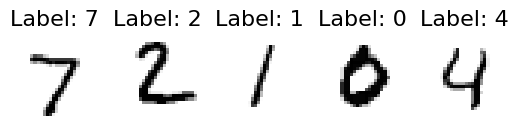

In [2]:
# download MNIST dataset
X_train, y_train, X_test, y_test = load_MNIST_28(flatten_images=False)
# X_train, y_train, X_test, y_test = load_MNIST_8(flatten_images=True)

# Display some images
plot_some_imgs(X_test, y_test)

In [3]:
print(X_train.shape)

(60000, 28, 28)


In [4]:
def single_run(X_train, X_test, y_train, y_test, 
               window_size_list=[3, 4],
               lr=0.01, lam=0.00001, epochs=300, batch_size=32, plot_or_not=False, 
               loss_func_and_name=(cross_entropy_loss_method, "CE"), #(MSELoss_method, "MSE")
               test_func_and_name=(cross_entropy_loss_method, "CE"), 
               result_filepath=None, store_params=False, intermediate_epochs=None):    
    """
    Performs a training with the given parameters

    Returns result, including the final accuracy scores
    """

    # Initialise beta and create the model
    beta0 = _beta_init_conv((X_train.shape[1], X_train.shape[2]), window_size_list)
    model = jit(convolutional_model_old)

    # Create gradient from loss function
    loss_func = jit(loss_func_and_name[0](model=model, lam=lam))   
    loss_grad = jit(grad(loss_func))

    # (usually MSE) loss function for evaluation
    if plot_or_not:
        test_func = jit(test_func_and_name[0])
        test_func = loss_func
    else:
        test_func = None

    # Perform training. We use adam, add the test index
    result = SGD_adam(X_train, y_train, X_test, y_test, 
                      grad_method=loss_grad,beta0=beta0, 
                      n_epochs=epochs, batch_size=batch_size,
                      test_loss_func= test_func, lr=lr, 
                      intermediate_epochs=intermediate_epochs)

    # Plot if wanted ...
    if plot_or_not:
        plot_test_results(result["test_loss_list"], result["train_loss_list"], ylabel="CE")

    # Add accuracy scores
    result["test_accuracy"]  = accuracy_func(model, result["beta_final"], X_test, y_test)
    result["train_accuracy"] = accuracy_func(model, result["beta_final"], X_train, y_train)
    # Also store the model for potential later use
    result["model"] = model

    # Store the result to given file
    if result_filepath:

        _dict_to_store =  { "lr"                : lr, 
                            "lam"               : lam,
                            "batch_size"        : batch_size,
                            "train_num"         : y_train.shape[0],
                            "test_num"          : y_test.shape[0],
                            "loss_function"     : loss_func_and_name[1],                            
                            "window_size_list" : f"{window_size_list}",
                          }
        if store_params:
            _dict_to_store["beta_final"] = {key: value.tolist() for key, value in result["beta_final"].items()}

        # Possibility of storing run with fewer epochs
        if intermediate_epochs is not None:
            for ie, be in zip(intermediate_epochs, result["beta_intermediate"]):
                _dict_to_store = {"test_accuracy"     : accuracy_func(model, be, X_test, y_test), 
                                  "train_accuracy"    : accuracy_func(model, be, X_train, y_train),
                                  "epochs"            : ie} | _dict_to_store

                append_run_to_file(result_filepath, _dict_to_store)

        _dict_to_store = {"test_accuracy"     : result["test_accuracy"], 
                          "train_accuracy"    : result["train_accuracy"],
                          "epochs"            : epochs} | _dict_to_store
        append_run_to_file(result_filepath, _dict_to_store)

    return result


## A demonstration
epochs = 50
batch_size = 128 #4096 2048 # 128 # 1024
lr = 0.02 # 0.01
lam = 0.00001

result = single_run(X_train, X_test, y_train, y_test, 
                    lr=lr, lam=lam, 
                    epochs=epochs, batch_size=batch_size, 
                    plot_or_not=True, result_filepath="test.json")

print("test: ", result["test_accuracy"])
print("train: ", result["train_accuracy"])

print("CE test: ", result["test_loss_list"][-1])
print("CE train: ", result["train_loss_list"][-1])

 52%|█████▏    | 26/50 [03:43<04:05, 10.23s/it]